# FDP - Understanding Depression through XAI
Tamara Pérez Pérez



## Table of contents<a class="anchor" id="index"></a>

[Modeling Data](#modeling-data)
* [Imports](#imports)
* [Total Dataset](#total-dataset)
   * [Decision Tree Classifier](#dtree-total)
   * [Explainable Boosting Classifier](#ebm-total)
   * [Random Forest](#rf-total)
       * [SHAP](#shap-total)
       * [LIME](#lime-total)

## Modeling Data: Total Dataset<a class="anchor" id="modeling-data"></a>

### Imports<a class="anchor" id="imports"></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from interpret.glassbox import (ClassificationTree,
                                ExplainableBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from interpret.blackbox import LimeTabular
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.combine import SMOTETomek
from interpret import show
from interpret.provider import InlineProvider
from interpret import set_visualize_provider
set_visualize_provider(InlineProvider())
import lime
from lime import lime_tabular
import shap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%run functions.ipynb

### Total Dataset<a class="anchor" id="total-dataset"></a>

Read the CSV file into a DataFrame and display information about the dataset.

In [2]:
df = pd.read_csv('../csv/df.csv',index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 73557 to 83727
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        5372 non-null   object 
 1   age                           5372 non-null   int64  
 2   race                          5372 non-null   object 
 3   education_level               5372 non-null   object 
 4   marital_status                5372 non-null   object 
 5   people_in_the_household       5372 non-null   int64  
 6   annual_household_income       5372 non-null   int64  
 7   citizenship_status            5372 non-null   object 
 8   total_cholesterol             5372 non-null   float64
 9   HDL-cholesterol               5372 non-null   float64
 10  LDL-cholesterol               5372 non-null   float64
 11  triglyceride                  5372 non-null   float64
 12  lymphocyte_percent            5372 non-null   float64
 13

Preprocessing data: One-hot encode categorical columns (object columns and binary answers)

In [3]:
df = preprocess_binary_responses(df)
df = one_hot_encode_object_columns(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 73557 to 83727
Data columns (total 80 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        5372 non-null   int64  
 1   people_in_the_household                    5372 non-null   int64  
 2   annual_household_income                    5372 non-null   int64  
 3   total_cholesterol                          5372 non-null   float64
 4   HDL-cholesterol                            5372 non-null   float64
 5   LDL-cholesterol                            5372 non-null   float64
 6   triglyceride                               5372 non-null   float64
 7   lymphocyte_percent                         5372 non-null   float64
 8   monocyte_percent                           5372 non-null   float64
 9   neutrophils_percent                        5372 non-null   float64
 10  eosinophils_percent

Split the dataset into training and testing sets using an 80-20 split

In [4]:
X_train, X_test, y_train, y_test = split_data(df, target_column='depression_status', test_size=0.2, random_state=42)

### Decision Tree Classifier<a class="anchor" id="dtree-total"></a>

Train a Decision Tree Classifier and evaluate its performance

____________________________________________________________

CLASSIFICATION REPORT FOR: DECISION TREE CLASSIFIER
____________________________________________________________
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       974
           1       0.33      0.05      0.09       101

    accuracy                           0.90      1075
   macro avg       0.62      0.52      0.52      1075
weighted avg       0.86      0.90      0.87      1075

AUC-PR: 0.90


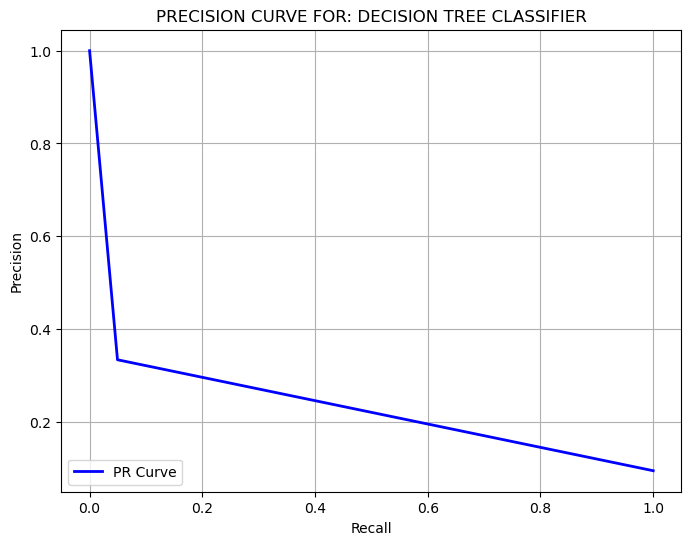

In [5]:
dt = ClassificationTree(random_state=42)
dt.fit(X_train, y_train)
analyze_results(dt, X_train, X_test, y_test, title='DECISION TREE CLASSIFIER')

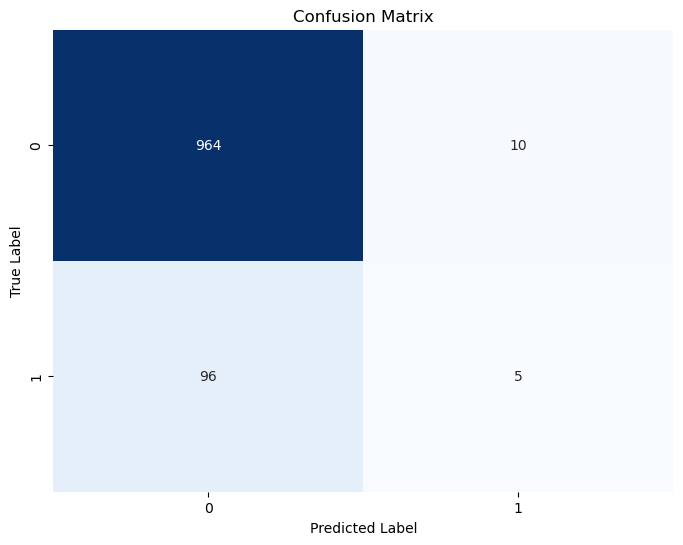

True Negatives: 964
True Positives: 5
False Positives: 10
False Negatives: 96


In [6]:
print_confusion_matrix(dt, X_test, y_test)

The results for class 1 (depression) are unsatisfactory. We will attempt oversampling to balance the data.

In [7]:
X_train_over, y_train_over = oversample_data(X_train, y_train, strategy='auto')

Before oversampling: [(0, 3887), (1, 410)]
After oversampling: [(0, 3887), (1, 3887)]


Train a new Decision Tree classifier and evaluate its performance

____________________________________________________________

CLASSIFICATION REPORT FOR: DECISION TREE CLASSIFIER
____________________________________________________________
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       974
           1       0.19      0.59      0.29       101

    accuracy                           0.73      1075
   macro avg       0.57      0.67      0.56      1075
weighted avg       0.88      0.73      0.78      1075

AUC-PR: 0.73


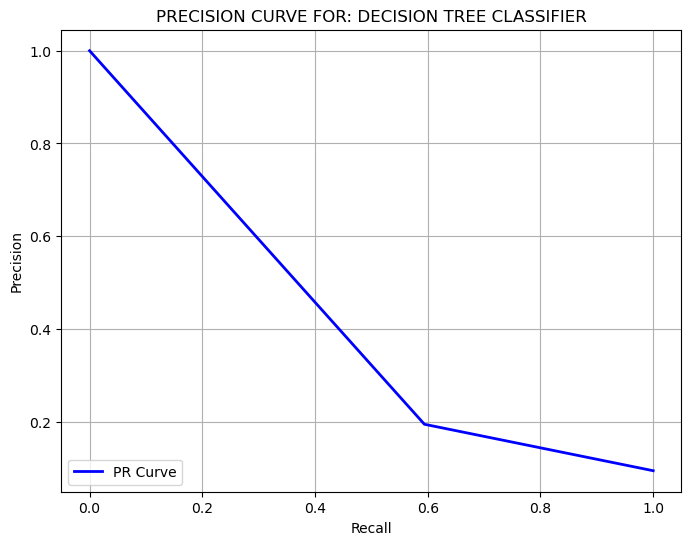

In [9]:
dt2 = ClassificationTree(random_state=42)
dt2.fit(X_train_over, y_train_over)
analyze_results(dt2, X_train_over, X_test, y_test, title='DECISION TREE CLASSIFIER')

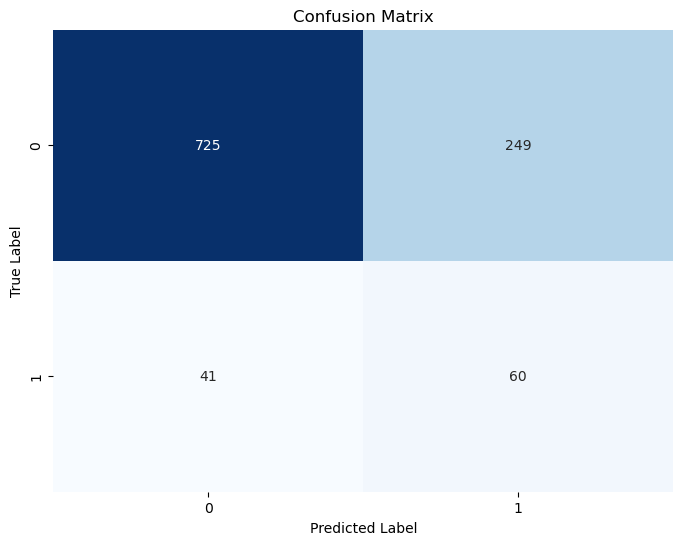

True Negatives: 725
True Positives: 60
False Positives: 249
False Negatives: 41


In [10]:
print_confusion_matrix(dt2, X_test, y_test)

Despite a slight improvement in performance, the results are not still optimal.  
To gain insights and explanations, we will utilize the InterpretML package.

In [11]:
# Explain the global model
dt_global = dt2.explain_global(name="Classification Tree")
show(dt_global)

<!-- http://127.0.0.1:7001/2295846635600/ -->

In [12]:
# Explain the local model
dt_local = dt2.explain_local(X_test, y_test, name="Classification Tree")
show(dt_local)

<!-- http://127.0.0.1:7001/2295868768464/ -->

### Explainable Boosting Classifier<a class="anchor" id="ebm-total"></a>

Train an Explainable Boosting classifier and evaluate its performance before and after oversampling

____________________________________________________________

CLASSIFICATION REPORT FOR: EXPLAINABLE BOOSTING CLASSIFIER
____________________________________________________________
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       974
           1       0.30      0.03      0.05       101

    accuracy                           0.90      1075
   macro avg       0.60      0.51      0.50      1075
weighted avg       0.85      0.90      0.86      1075

AUC-PR: 0.90


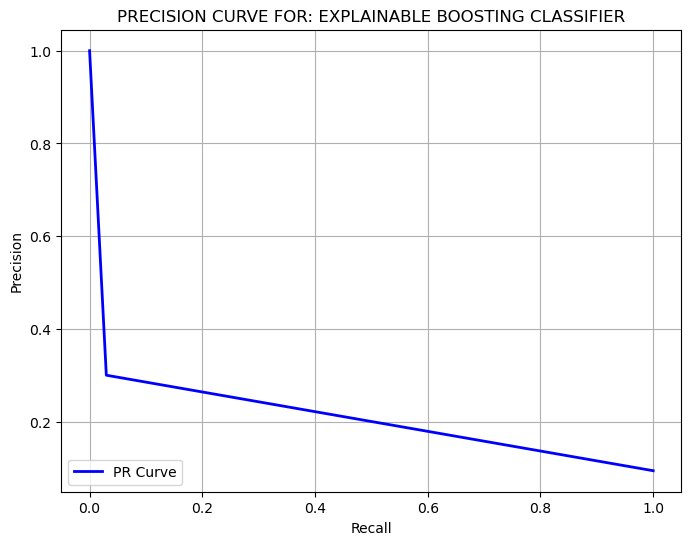

In [13]:
ebm1 = ExplainableBoostingClassifier(random_state=42)
ebm1.fit(X_train, y_train)
analyze_results(ebm1, X_train, X_test, y_test, title='EXPLAINABLE BOOSTING CLASSIFIER')

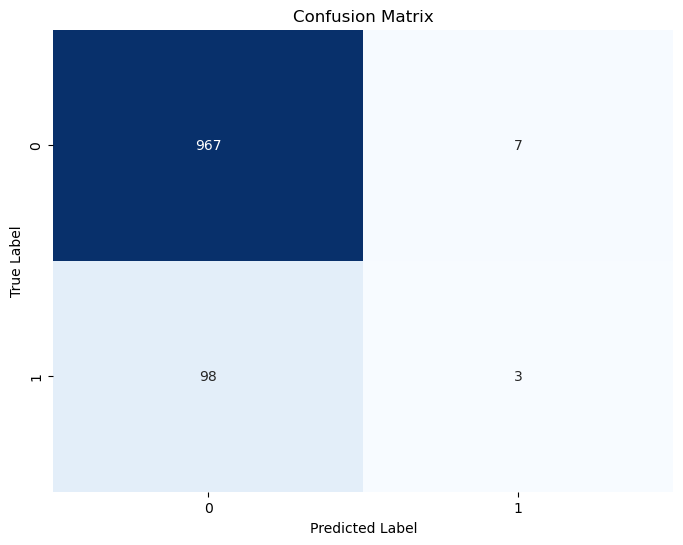

True Negatives: 967
True Positives: 3
False Positives: 7
False Negatives: 98


In [14]:
print_confusion_matrix(ebm1, X_test, y_test)

____________________________________________________________

CLASSIFICATION REPORT FOR: EXPLAINABLE BOOSTING CLASSIFIER
____________________________________________________________
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       974
           1       0.19      0.22      0.20       101

    accuracy                           0.84      1075
   macro avg       0.55      0.56      0.56      1075
weighted avg       0.85      0.84      0.84      1075

AUC-PR: 0.84


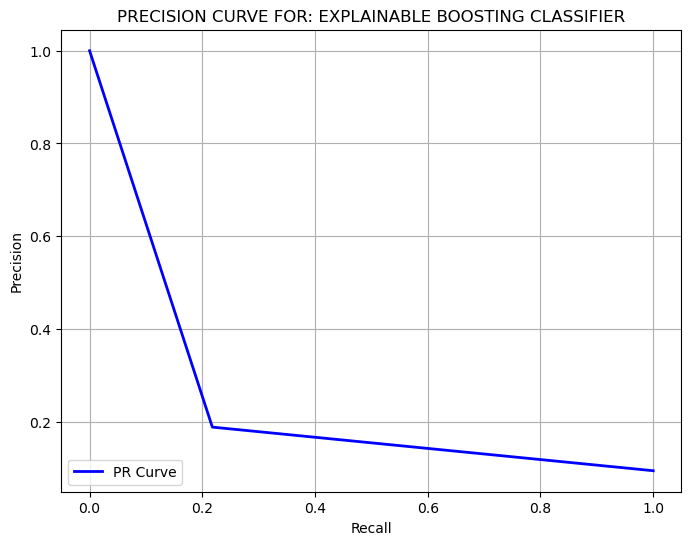

In [24]:
ebm2 = ExplainableBoostingClassifier(random_state=42)
ebm2.fit(X_train_over, y_train_over)
analyze_results(ebm2, X_train_over, X_test, y_test, title='EXPLAINABLE BOOSTING CLASSIFIER')

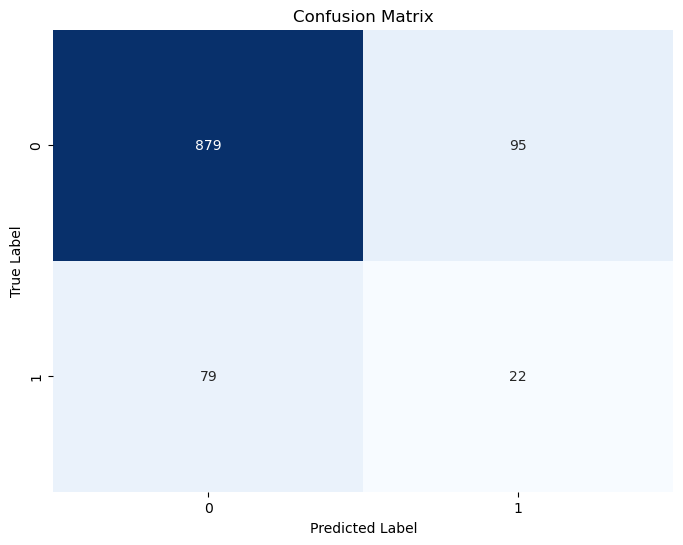

True Negatives: 879
True Positives: 22
False Positives: 95
False Negatives: 79


In [25]:
print_confusion_matrix(ebm2, X_test, y_test)

Obtain global explanations using the InterpretML package

In [ ]:
# Explain the global model
ebm_global = ebm.explain_global(name="EBM")
show(ebm_global)

Obtain local explanations using the InterpretML package

In [ ]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

### Random Forest<a class="anchor" id="rf-total"></a>
<!-- Best results with parameters: n_estimators=200, random_state=42, class_weight='balanced',max_depth=5, min_samples_split=30
Don't oversample or undersample data. Model able to balance data. -->

Create a RandomForestClassifier with balanced class weights, train the model on the training data, and analyze the results.

____________________________________________________________

CLASSIFICATION REPORT FOR: 
____________________________________________________________
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       974
           1       1.00      0.00      0.00       101

    accuracy                           0.91      1075
   macro avg       0.95      0.50      0.48      1075
weighted avg       0.91      0.91      0.86      1075

AUC-PR: 0.91


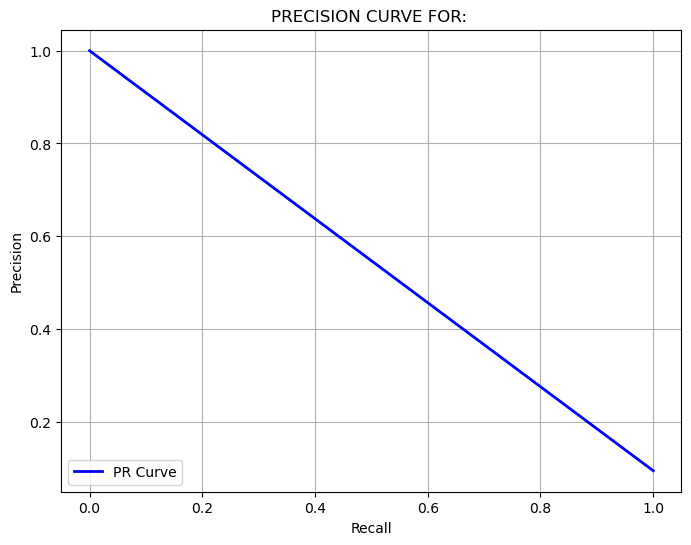

In [269]:
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)
analyze_results(rf_clf, X_train, X_test, y_test)

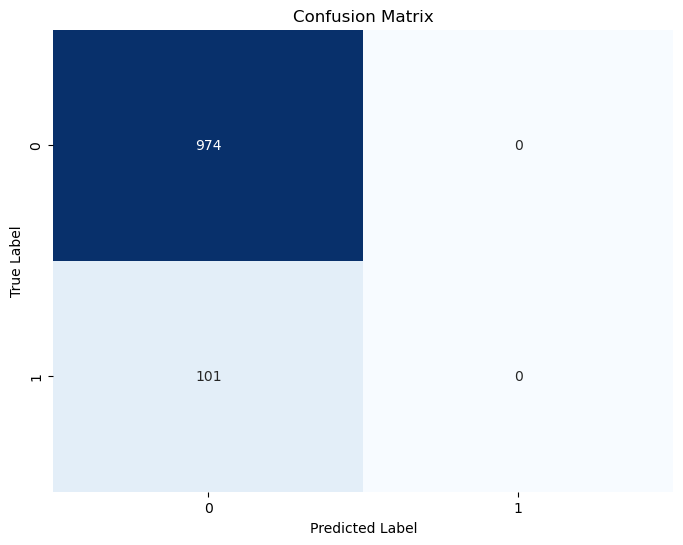

True Negatives: 974
True Positives: 0
False Positives: 0
False Negatives: 101


In [270]:
print_confusion_matrix(rf_clf, X_test, y_test)

The performance for class 1 is unsatisfactory. We will attempt to improve it by searching for the best parameters using GridSearchCV.

In [27]:
best_params_rf = {'criterion': ['gini', 'entropy'],
                  'max_depth': [3,4,5,6], 
                  'min_samples_split': [25,30,35],
                  'class_weight': ['balanced', 'balanced_subsample'], 
                  'n_estimators': [100,200,300]}

grid = GridSearchCV(rf_clf, best_params_rf, cv=5, scoring='accuracy')
rf_grid = grid.fit(X_train, y_train)

In [28]:
rf_grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_split': 25,
 'n_estimators': 300}

____________________________________________________________

CLASSIFICATION REPORT FOR: 
____________________________________________________________
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       974
           1       0.31      0.49      0.38       101

    accuracy                           0.85      1075
   macro avg       0.63      0.69      0.65      1075
weighted avg       0.88      0.85      0.86      1075

AUC-PR: 0.85


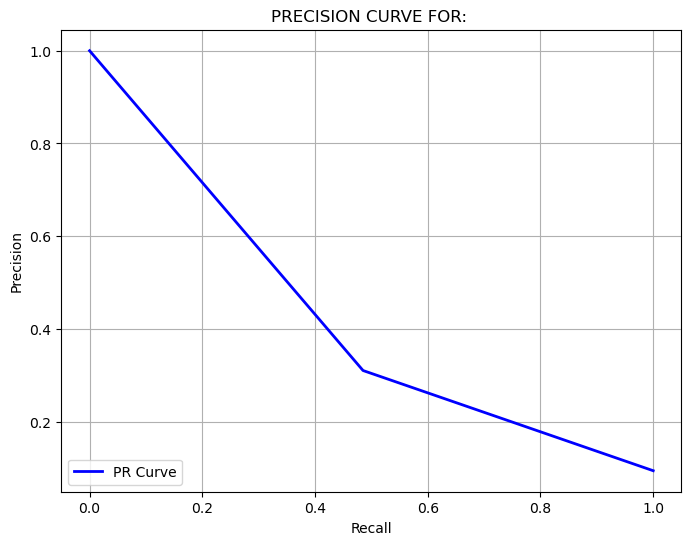

In [29]:
rf_grid = rf_grid.best_estimator_
analyze_results(rf_grid, X_train, X_test, y_test)

____________________________________________________________

CLASSIFICATION REPORT FOR: 
____________________________________________________________
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       974
           1       0.32      0.49      0.38       101

    accuracy                           0.85      1075
   macro avg       0.63      0.69      0.65      1075
weighted avg       0.88      0.85      0.87      1075

AUC-PR: 0.85


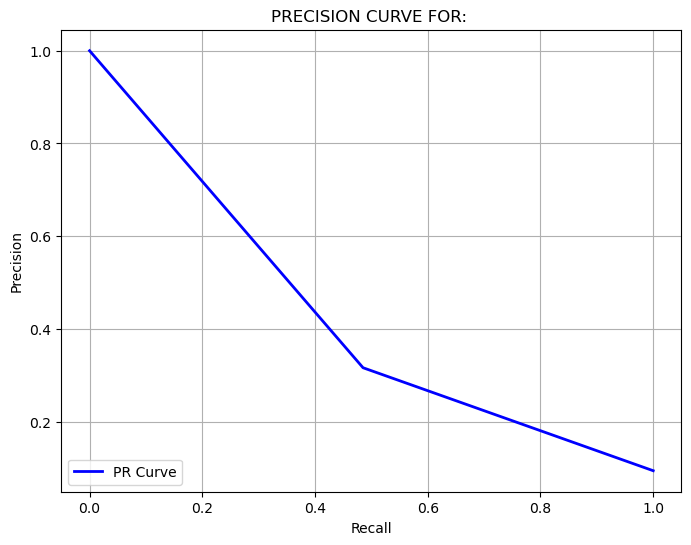

In [16]:
# rf_grid = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample',
#                                 max_depth=6, min_samples_split=25,random_state=42,
#                                 criterion='gini')
# rf_grid.fit(X_train, y_train)
# analyze_results(rf_grid, X_train, X_test, y_test)

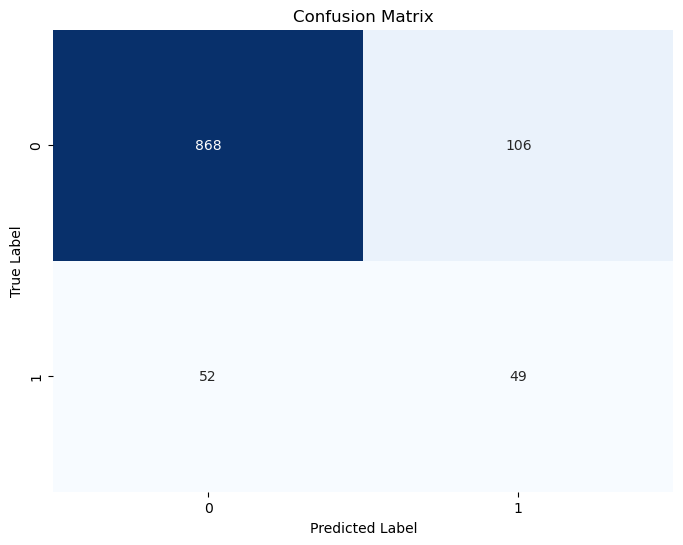

True Negatives: 868
True Positives: 49
False Positives: 106
False Negatives: 52


In [17]:
print_confusion_matrix(rf_grid, X_test, y_test)

Despite a performance increase, the overall results are still suboptimal. To gain insights, we will utilize SHAP for local and global explanations and LIME for local explanations.

### SHAP<a class="anchor" id="shap-total"></a>

Obtain global explanations for the first 20 instances using SHAP

Prediction: 0


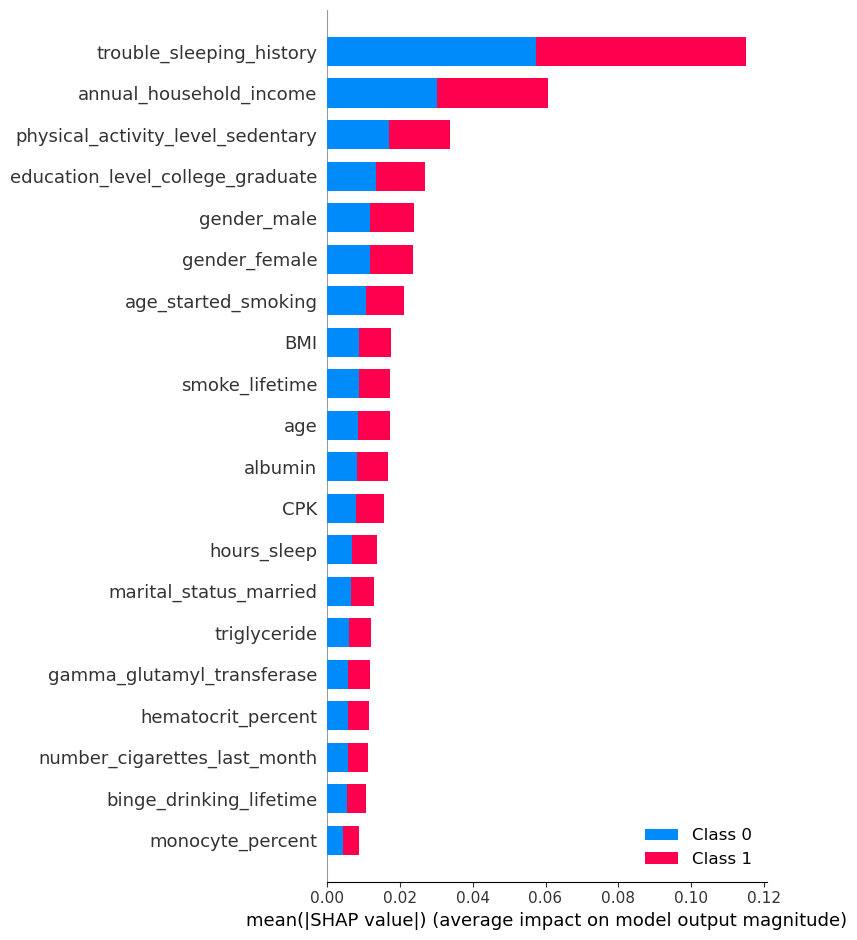

None

In [41]:
shap.initjs()
shap_explanation(rf_grid, X_test, start_index=0, end_index=19)

Obtain  explanations for instance 2 (Not Depressed)

Prediction: 0


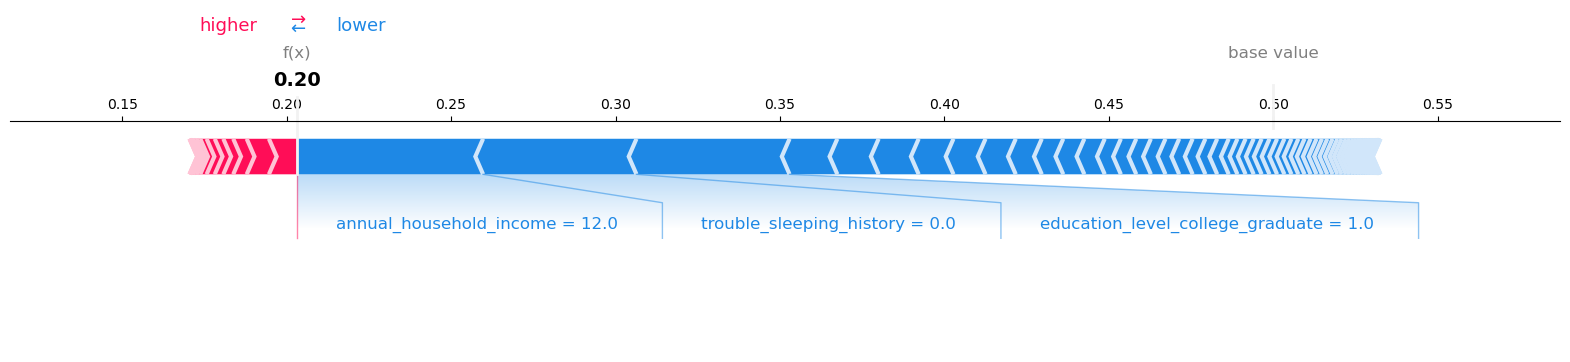

None

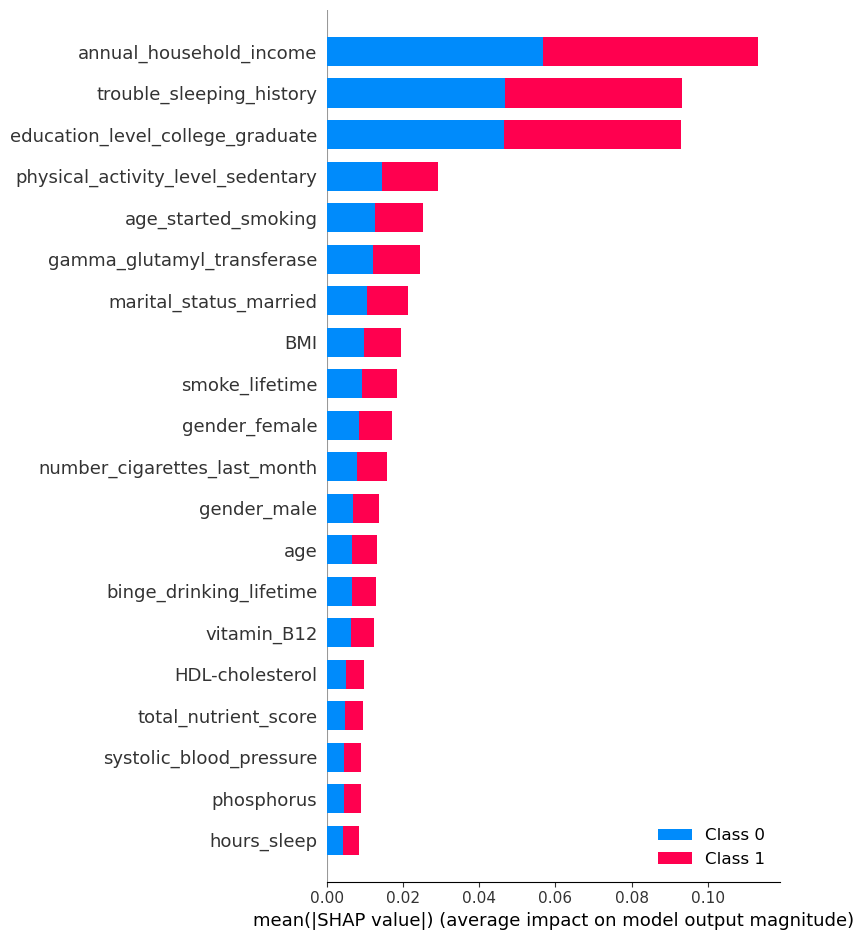

None

In [42]:
shap.initjs()
shap_explanation(rf_grid, X_test, start_index=2, end_index=3)

Obtain  explanations for instance 108 (Depressed)

Prediction: 1


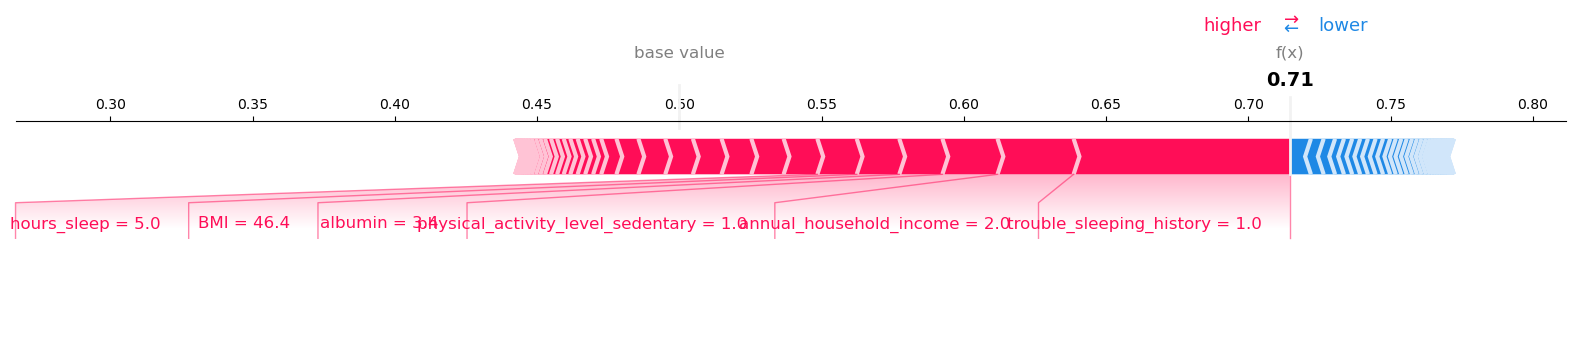

None

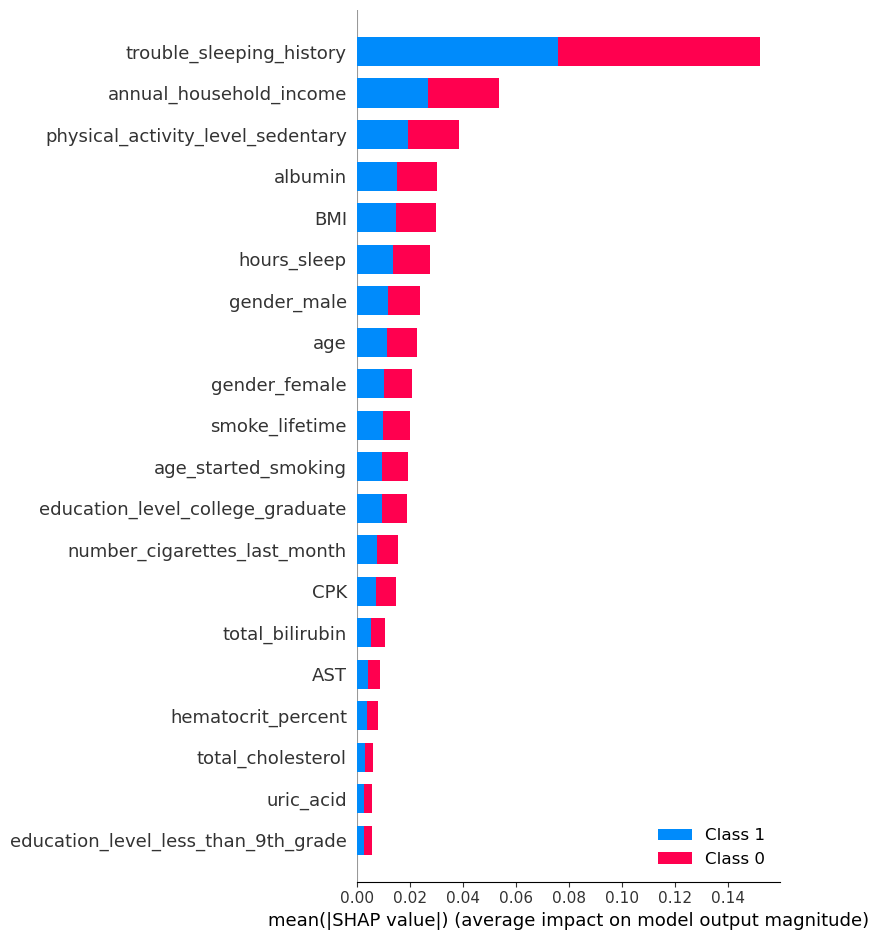

None

In [43]:
shap.initjs()
shap_explanation(rf_grid, X_test, start_index=108, end_index=109)

### LIME<a class="anchor" id="lime-total"></a>

Obtain local explanations for instance 2

In [21]:
lime_tabular_explainer(rf_grid, X_train, instance=2, num_features=10)

C:\Users\tamar\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Instance: 2


Obtain local explanations for instance 108

In [22]:
lime_tabular_explainer(rf_grid, X_train, instance=108, num_features=10)

C:\Users\tamar\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Instance: 108


Obtain local explanations for 110 instances with InterpretML

In [23]:
lime_explanation(rf_grid, X_test, y_test, start_index=0, end_index=110)

<!-- http://127.0.0.1:7001/2295873208384/ -->